# Network of Users

Creates a network of users who have reviewed similar releases.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import collections as clt

In [2]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [2]:
df = pd.read_csv('reviews_full_v7.csv')

In [4]:
df.shape

(93434, 14)

In [5]:
df.columns

Index(['Unnamed: 0', 'User', 'Date', 'Year', 'Month', 'Release', 'Band',
       'Score', 'Link', 'Album_link', 'Review_title', 'Genre', 'Text',
       'Sentiment'],
      dtype='object')

In [6]:
df

,Unnamed: 0,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,Genre,Text,Sentiment
0,0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,technical thrash metal|math metal|progressive ...,I originally bought Chaosphere in late 2000......,0.9728
1,1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,grindcore|melodic death metal,A midpoint between Carcass' early grind albums...,0.8479
2,2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,symphonic power metal,"I'm not hard-core into metal at all, really, b...",0.9951
3,3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,heavy metal|us power metal,"This is not a new album, but in fact, five alb...",0.9976
4,4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,power metal,I've been trying for months to come up with an...,0.5494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93429,93429,6CORPSE6GRINDER6,June 30 2017,2017,6,Chemical_Assault,Violator,85,https://www.metal-archives.com/reviews/Violato...,https://www.metal-archives.com/albums/Violator...,"Take your life back, in the pit!",thrash metal,I don't have any issues with the retro-thrash ...,0.9976
93430,93430,6CORPSE6GRINDER6,June 30 2017,2017,6,Path_of_Fire,Aeon,65,https://www.metal-archives.com/reviews/Aeon/Pa...,https://www.metal-archives.com/albums/Aeon/Pat...,As mediocre as it's predecessor,death metal,Aeon’s brand of death metal is supposed to be ...,-0.9758
93431,93431,6CORPSE6GRINDER6,June 30 2017,2017,6,Violent_Mosh,Violator,80,https://www.metal-archives.com/reviews/Violato...,https://www.metal-archives.com/albums/Violator...,Officers are dirtier than the criminals they c...,thrash metal,This band was so important for the thrash meta...,0.9911
93432,93432,Wacke,June 30 2017,2017,6,Resurrection,Chimaira,89,https://www.metal-archives.com/reviews/Chimair...,https://www.metal-archives.com/albums/Chimaira...,What doesn't kill us makes us stronger.,hard rock,Chimaira is arguably the most overlooked and/o...,0.9947


In [7]:
df.describe()

,Unnamed: 0,Year,Month,Score,Sentiment
count,93434.000000,93434.000000,93434.000000,93434.000000,93434.000000
mean,46716.500000,2010.178661,6.432284,77.220905,0.524681
std,26972.216863,3.782777,3.419481,20.475495,0.752522
min,0.000000,2002.000000,1.000000,0.000000,-1.000000
25%,23358.250000,2007.000000,4.000000,70.000000,0.421500
50%,46716.500000,2010.000000,6.000000,83.000000,0.974400
75%,70074.750000,2013.000000,9.000000,90.000000,0.994500
max,93433.000000,2017.000000,12.000000,100.000000,1.000000


In [8]:
np.median([i for i in clt.Counter(df['User']).values()])

2.0

In [9]:
clt.Counter(clt.Counter(df['User']).values())[2]

1460

In [10]:
users = set(df['User'])

In [11]:
len(users)

9317

In [12]:
#posScore = df['Score'].quantile(.5)
posScore = 75

In [13]:
np.mean(df['Score'])

77.22090459575743

In [14]:
print("Positive Score Threshold =",posScore)

Positive Score Threshold = 75


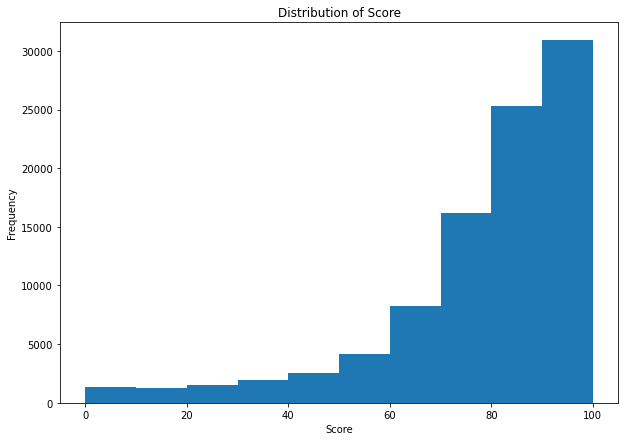

In [15]:
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.hist(df['Score'])
plt.savefig("Distribution of Score.png")
plt.show()

In [16]:
G = nx.Graph() #network of users
B = nx.Graph() #bipartite graph between users and releases
G.add_nodes_from(users)
B.add_nodes_from(users)

In [17]:
#construction of bipartite graph between users and releases
bandmp = {}
for index, row in df.iterrows():
    if row['Score'] >= posScore:#positive review is defined as score >= 75
    #if df['Score'][i] == 100:#only consider positive review as full score of 100
        B.add_edge(row['Release'] + 'R', row['User'])#added 'R' as some user names are the same as review names
        B[row['Release']+ 'R'][row['User']]['year'] = row['Year']
        #users.add(df['User'][i]) #removing isolated nodes
    #connect release to band, assuming each release only has one band
    #if df['Release'][i] in band and band[df['Release'][i]] != df['Band'][i]:
        #print("Error at index",i)
        bandmp[row['Release']+ 'R'] = row['Band']

In [18]:
#constructing edges, and counting the frequency (i.e. number of repeated edges)
for user in users:
    for release in B.adj[user]:
        for node in B.adj[release]:
            if node < user: #to ensure the order, with no repeats
                if not G.has_edge(user,node):
                    G.add_edge(user, node, weight = 0, releases = [], year = {})
                G[user][node]['weight'] += 1
                G[user][node]['releases'].append(release)
                year = max(B[node][release]['year'],B[user][release]['year'])
                if year not in G[user][node]['year']:
                    G[user][node]['year'][year] = 0
                G[user][node]['year'][year] += 1

In [19]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

In [20]:
G = calc_sim(G)

In [21]:
len(G.nodes())

9317

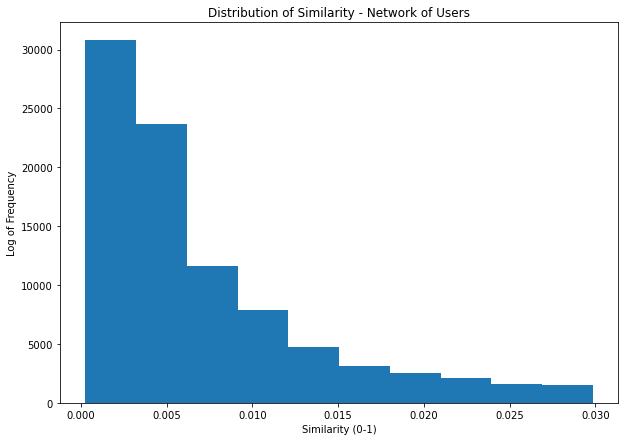

In [22]:
sim_score = [G[u][v]['similarity'] for u,v in G.edges() if G[u][v]['similarity'] < 0.03]
#print(weights)
plt.title('Distribution of Similarity - Network of Users')
plt.xlabel('Similarity (0-1)')
plt.ylabel('Log of Frequency')
#print(min(sim_score))
plt.hist(sim_score)#specify the number of bins -> 
#plt.savefig("/images/Distribution of Similarity - Network of Users.png")
plt.show()

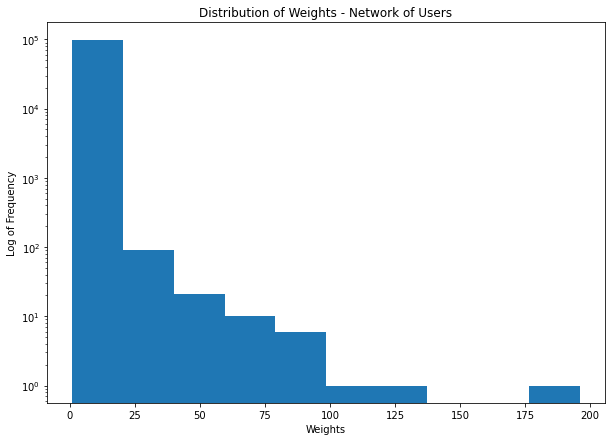

In [23]:
#Assigning weights based on frequency
weights = [G[u][v]['weight'] for u,v in G.edges()]
plt.title('Distribution of Weights - Network of Users')
plt.xlabel('Weights')
plt.ylabel('Log of Frequency')
plt.hist(weights, log = True)
#plt.savefig("/images/Distribution of Weights - Network of Users.png")
plt.show()

In [24]:
print("Maximum Weight (i.e. Frequency) =",max(weights))
print("Number of edges =",len(weights))
print("Number of nodes =",len(G.nodes()))

Maximum Weight (i.e. Frequency) = 196
Number of edges = 99548
Number of nodes = 9317


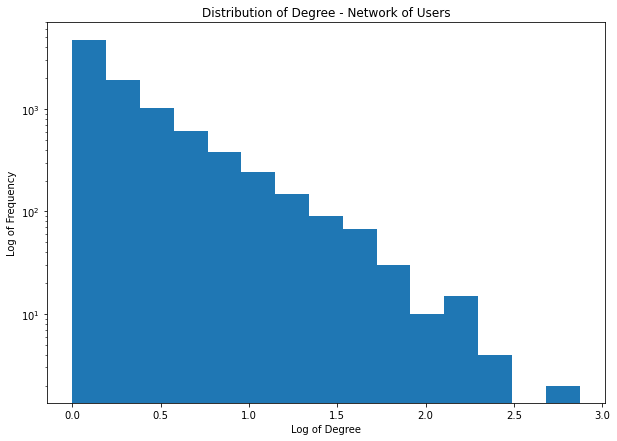

In [25]:
plt.title('Distribution of Degree - Network of Users')
plt.xlabel('Log of Degree')
plt.ylabel('Log of Frequency')
data = np.log10([b+10 for a,b in G.degree(list(G.nodes()), weight = 'weight')])-1 #+10 to account for 0 case
#_,bins = np.histogram(data + 1, bins='auto')
#data = [b for a,b in G.degree(list(G.nodes()))]
#plt.gca().set_xscale('log')
plt.hist(data, log = True, bins = 15)
#plt.savefig("/images/Distribution of Degree - Network of Users.png")
plt.show()
#print([b for a,b in G.degree(list(G.nodes()))])
#Hopefully able to observe Power Law Distribution

In [26]:
#Only run this when size is small
#nx.draw(G, node_size = 10, width = weights)
#plt.show()

In [27]:
clt.Counter(sorted([len(cc) for cc in nx.connected_components(G)]))

Counter({1: 2158, 2: 45, 3: 4, 4: 1, 7053: 1})

In [28]:
#Splitting the graph into connected subgraphs
'''
graphs = list(nx.connected_components(G))

for subgraph in graphs:
    if len(subgraph) < 3:#only consider subgraphs with size > 3
        continue
    graph = G.subgraph(subgraph)
    weights1 = [graph[u][v]['weight'] for u,v in graph.edges()]
    nx.draw(graph, node_size = 10, width = weights1)
    plt.show()
'''

"\ngraphs = list(nx.connected_components(G))\n\nfor subgraph in graphs:\n    if len(subgraph) < 3:#only consider subgraphs with size > 3\n        continue\n    graph = G.subgraph(subgraph)\n    weights1 = [graph[u][v]['weight'] for u,v in graph.edges()]\n    nx.draw(graph, node_size = 10, width = weights1)\n    plt.show()\n"

In [29]:
'''H = nx.Graph() #network of releases'''

'H = nx.Graph() #network of releases'

In [30]:
'''#constructing edges, and counting the frequency (i.e. number of repeated edges)
edgesNew = {}
for release in mp:
    for item in B.adj[release]:
        for node in B.adj[item]:
            if node != release:
                if (release, node) in edgesNew:
                    edgesNew[(release, node)] += 1
                elif (node, release) in edgesNew:
                    edgesNew[(node, release)] += 1
                else:
                    edgesNew[(release, node)] = 1

for edge in edgesNew:
    H.add_edge(edge[0], edge[1], weight = edgesNew[edge]/2)#double counted

#Assigning weights based on frequency
weightsNew = [H[u][v]['weight'] for u,v in H.edges()]'''

"#constructing edges, and counting the frequency (i.e. number of repeated edges)\nedgesNew = {}\nfor release in mp:\n    for item in B.adj[release]:\n        for node in B.adj[item]:\n            if node != release:\n                if (release, node) in edgesNew:\n                    edgesNew[(release, node)] += 1\n                elif (node, release) in edgesNew:\n                    edgesNew[(node, release)] += 1\n                else:\n                    edgesNew[(release, node)] = 1\n\nfor edge in edgesNew:\n    H.add_edge(edge[0], edge[1], weight = edgesNew[edge]/2)#double counted\n\n#Assigning weights based on frequency\nweightsNew = [H[u][v]['weight'] for u,v in H.edges()]"

In [31]:
#Only run this when size is small
#nx.draw(H, node_size = 10, width = weightsNew)
#plt.show()

In [32]:
#GC = nx.Graph(G.subgraph(list(nx.connected_components(G))[0]))#giant component of network of users, nx.Graph is to unfreeze graph

In [33]:
mp = clt.Counter(df['User'])
remove_users = [user for user in users if mp[user] < 3]

In [34]:
len(G.nodes()),len(remove_users)

(9317, 5567)

In [35]:
G1 = nx.Graph(G) #Copy of graph G

In [36]:
G1.remove_nodes_from(remove_users)
tmp = list(nx.isolates(G1))
print(len(tmp))
G1.remove_nodes_from(tmp)

174


In [37]:
nx.number_connected_components(G1)

1

In [38]:
clt.Counter(sorted([len(cc) for cc in nx.connected_components(G1)]))

Counter({3576: 1})

In [39]:
GC = G1 #G1 is just one giant component

In [40]:
len(GC.nodes())

3576

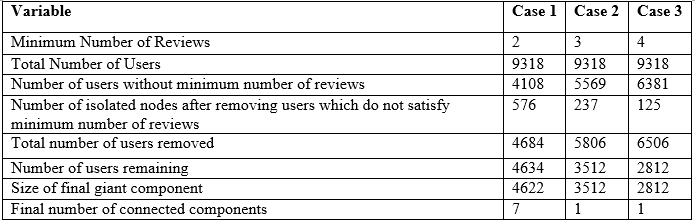

In [41]:
#This portion takes into account only Giant Component
#binning node degrees by log factor (i.e. each bin has the range  [a^x,a^(x+1)))
powers = []
for node in GC.nodes():
    powers.append(1.1**math.floor(math.log(GC.degree(node,weight = 'weight'),1.1)))

degree_x = []
degree_y = []
d_freq = clt.Counter(powers)
for item in d_freq:
    degree_x.append(math.log10(math.sqrt(item*(item*1.1))))
    degree_y.append(math.log10(d_freq[item]))
#finding best fit line
m,c = np.polyfit(degree_x,degree_y,1)#polynomial degree 1 (i.e. linear)
print(m,c)

-0.7004357196776326 2.7957967889997817


In [42]:
y_pred = [m*x + c for x in degree_x]
MSE = np.square(np.subtract(degree_y,y_pred)).mean()
print("Mean Squared Error =", MSE)

Mean Squared Error = 0.07561648218571947


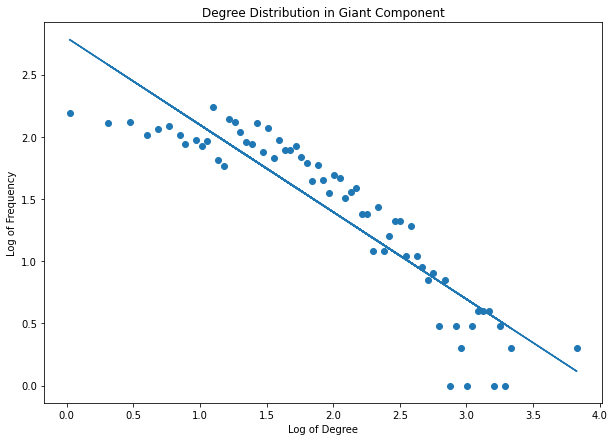

In [43]:
plt.title('Degree Distribution in Giant Component')
plt.xlabel('Log of Degree')
plt.ylabel('Log of Frequency')
plt.scatter(degree_x,degree_y)
plt.plot(degree_x,m*np.array(degree_x)+c)
plt.savefig('Degree Distribution in Giant Component')

In [44]:
#Power Law Window
#binning node degrees by log factor (i.e. each bin has the range  [a^x,a^(x+1)))
powers = []
for node in GC.nodes():
    powers.append(1.1**math.floor(math.log(GC.degree(node,weight = 'weight'),1.1)))

degree_x = []
degree_y = []
d_freq = clt.Counter(powers)
for item in d_freq:
    x = math.log10(math.sqrt(item*(item*1.1)))
    if x > 1 and x < 2.5:
        degree_x.append(x)
        degree_y.append(math.log10(d_freq[item]))
#finding best fit line
m,c = np.polyfit(degree_x,degree_y,1)#polynomial degree 1 (i.e. linear)
print(m,c)

-0.5956734264048014 2.7747715987730217


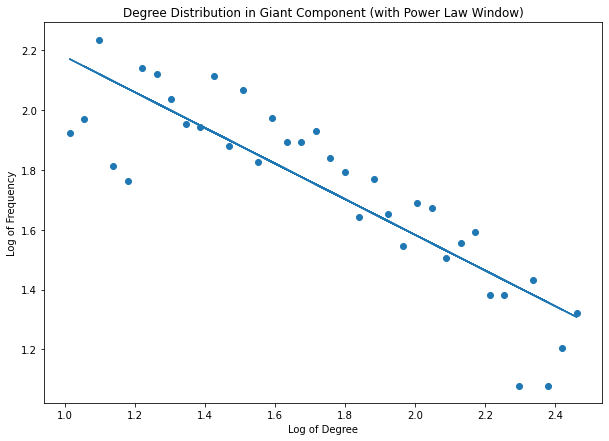

In [45]:
plt.title('Degree Distribution in Giant Component (with Power Law Window)')
plt.xlabel('Log of Degree')
plt.ylabel('Log of Frequency')
plt.scatter(degree_x,degree_y)
plt.plot(degree_x,m*np.array(degree_x)+c)
plt.savefig('Degree Distribution in Giant Component (with Power Law Window)')
plt.show()

In [46]:
y_pred = [m*x + c for x in degree_x]
MSE = np.square(np.subtract(degree_y,y_pred)).mean()
print("Mean Squared Error =", MSE)

Mean Squared Error = 0.020666192305464997


In [47]:
def cluster(sim,params = True):
    #this function generates a graph which is a collection of subgraphs from the original graph
    #after removing all edges with similarity < sim, where sim is to be determined
    #to generate full graph, used for point query
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    for u,v in GC.edges():
        if GC[u][v]['similarity'] >= sim:
            GC_split.add_edge(u,v)
            if params == True:
                GC_split[u][v]['weight'] = GC[u][v]['weight']
                GC_split[u][v]['similarity'] = GC[u][v]['similarity']
                GC_split[u][v]['releases'] = GC[u][v]['releases']
                GC_split[u][v]['year'] = GC[u][v]['year']
    return GC_split

def components(Graph):
    #returns a list connected components of a graph (a list of lists of nodes in each connected component)
    return list(nx.connected_components(Graph))

def getSize(Graph):
    #returns a list of the size of disconnected subgraphs in a graph
    return [len(x) for x in list(nx.connected_components(Graph))]

def entropy(sim, Graph = nx.Graph()):
    #can be used both for range and point query
    #calculates the Shannon Entropy of a graph
    #if input is a graph instead of similarity value, set sim = -1
    sum = 0
    if sim == -1:#used by range function entropy_range
        clusters = components(Graph)
    else:#used individually
        clusters = components(cluster(sim,False))
    N = len(GC.nodes())
    for comp in clusters:
        P = len(comp)/N #P is the probability of a node being in a particular component/cluster
        sum += -1*P*math.log10(P)
    return sum

def entropy_range(sim_x, isShannon = False):
    #runs in linear time, but needs to be initialised from largest to smallest similarity
    #takes in a range of values and adds edges individually from greatest to smallest similarity
    #used for range query
    #isShannon is a boolean which is True when finding Shannon Entropy and False when finding Cluster Entropy
    #can be used for both types of entropy by specifying boolean
    #range query reduces run time as graph is only constructed once
    #returns list of entropy values
    pos = 0
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    edges = []
    for u,v in GC.edges():
        edges.append((GC[u][v]['similarity'],u,v))
    edges.sort(reverse = True)
    ret = []
    for sim in sim_x:
        for i in range(pos,len(edges)):
            edgesim, u, v = edges[i]
            if edgesim >= sim:
                GC_split.add_edge(u,v)
            else:
                break
        pos = i
        if isShannon:
            ret.append(entropy(-1,GC_split))
        else:
            ret.append(clusterentropy(-1,GC_split))
    ret.reverse()
    return ret

def clusterentropy(sim, Graph = nx.Graph()):
    #can be used both for range and point query
    #set sim = -1 if input is a graph
    if sim == -1:#used by range function entropy_range
        freq = clt.Counter(getSize(Graph))
    else:#used individually
        freq = clt.Counter(getSize(cluster(sim,False)))
    sum = 0
    N = len(Graph.nodes())
    for item in freq:
        P = item*freq[item]/N
        sum += -1*P*math.log10(P) # P is the probability of a cluster having a particular size X (X = item in this case)
    return sum

def entropy_rangemax(sim_x):
    #runs in linear time, but needs to be initialised from largest to smallest similarity
    #takes in a range of values and adds edges individually from greatest to smallest similarity
    #used for range query
    #Different from entropy_range
    #This returns the maximum entropy and the similarity value at which cluster entropy is maximum
    pos = 0
    GC_split = nx.Graph()
    GC_split.add_nodes_from(GC.nodes())
    edges = []
    for u,v in GC.edges():
        edges.append((GC[u][v]['similarity'],u,v))
    edges.sort(reverse = True)
    bestsim = -1
    maxi = -1
    for i1, sim in enumerate(sim_x):
        for i in range(pos,len(edges)):
            edgesim, u, v = edges[i]
            if edgesim >= sim:
                GC_split.add_edge(u,v)
            else:
                break
        pos = i
        x = clusterentropy(-1,GC_split)
        if x > maxi:
            maxi = x
            bestsim = sim
    return maxi,bestsim

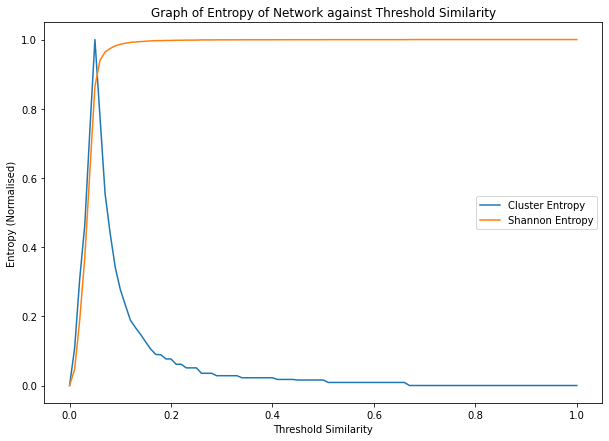

In [48]:
sim_x = [0.01*x for x in range(101)] 
sim_y = entropy_range(reversed(sim_x), True)
max_y = max(sim_y)
sim_y = [item/max_y for item in sim_y]
sim_y1 = entropy_range(reversed(sim_x))
max_y1 = max(sim_y1)
sim_y1 = [item/max_y1 for item in sim_y1]
#print(sim_y)
#sim_x = 0.04*np.array(range(0,26))
plt.title('Graph of Entropy of Network against Threshold Similarity')
plt.xlabel('Threshold Similarity')
plt.ylabel('Entropy (Normalised)')
plt.plot(sim_x,sim_y1, label = 'Cluster Entropy')
plt.plot(sim_x,sim_y, label = 'Shannon Entropy')
plt.legend()
plt.savefig('Graph of Entropy of Network against Threshold Similarity')
plt.show()

In [49]:
#Based on graph, calculate similarity that gives maximum certainty

#Searches with precision of 0.01 in entire range of similarity from 0-1
sim_x = [0.01*x for x in range(101)]#reversed
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)

#Searches with precision of 0.001 within new range based on previous search
sim_x = [0.001*x + sim for x in range(-10,10)]
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)

#Searches with precision of 0.0001 within new range based on previous search (if needed)
sim_x = [0.0001*x + sim for x in range(-10,10)]
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)

#Searches with precision of 0.00001 within new range based on previous search (if needed)
sim_x = [0.00001*x + sim for x in range(-10,10)]
maxi, sim = entropy_rangemax(reversed(sim_x))
print("Maximum Cluster Entropy:",maxi," when Similarity =",sim)
#Therefore, optimal similarity value is determined to be 0.0593
optsim = sim #this value is determined for when posScore = 75
#when posScore = 83 at 50th percentile, optsim = 0.67
print(optsim,maxi)

Maximum Cluster Entropy: 0.7841613163558605  when Similarity = 0.05
Maximum Cluster Entropy: 0.7963600276668859  when Similarity = 0.051000000000000004
Maximum Cluster Entropy: 0.7967655485774257  when Similarity = 0.0504
Maximum Cluster Entropy: 0.7967655485774257  when Similarity = 0.05042
0.05042 0.7967655485774257


In [50]:
DG = cluster(optsim)#disjointed graph (i.e. after removing edges with similarity < optsim )
comp = components(DG)

In [51]:
len(comp)

2372

In [52]:
#finding size of subgraphs in new graph generated with optsim
dist_size = []
tmp = clt.Counter(len(x) for x in comp)
for y in tmp:
    dist_size.append((y,tmp[y]))
dist_size = sorted(dist_size)
print(dist_size)

[(1, 2022), (2, 191), (3, 60), (4, 32), (5, 16), (6, 7), (7, 11), (8, 8), (9, 9), (10, 3), (12, 1), (13, 1), (15, 2), (16, 1), (17, 1), (27, 1), (45, 1), (49, 1), (51, 1), (53, 1), (80, 1), (97, 1)]


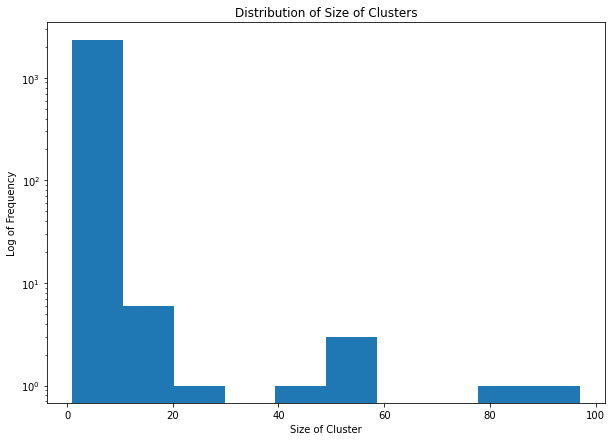

In [53]:
plt.title('Distribution of Size of Clusters')
plt.xlabel('Size of Cluster')
plt.ylabel('Log of Frequency')
plt.hist([len(x) for x in comp], log = True)
#plt.savefig('/images/Distribution of Size of Clusters')
plt.show()

In [54]:
#sorted descending list of all components (i.e. subgraphs) according to size
comps = [y[1] for y in sorted([(len(x),list(x)) for x in components(DG)], reverse = True)]

In [55]:
def filter_year(Graph, years, isolate = True):
    #returns graph with only edges from the list of years specified
    Y = nx.Graph()
    if isolate == True:
        Y.add_nodes_from(Graph.nodes()) #this line can be added if isolated nodes are also displayed
    for u,v in Graph.edges():
        for year in years:
            if year in Graph[u][v]['year']:
                Y.add_edge(u,v)
                Y[u][v]['weight'] = Graph[u][v]['year'][year]
    return calc_sim(Y)

def get_subgraph(ind, years = [], calc = False):
    #if calc == False, returns subgraph with widths for network drawing
    #else returns the mean similairity and number of components
    SG = DG.subgraph(comps[ind])
    if len(years) != 0:
        SG = filter_year(SG, years)
    widths = np.array([SG[u][v]['similarity'] for u,v in SG.edges()])
    N = len(SG.nodes())
    #meanSim = np.sum(widths)/((N*(N-1))/2) #N*(N-1)/2 is total number of possible edges
    if len(widths) == 0:
        meanSim = np.nan #0 case
    else:
        meanSim = np.mean(widths)#mean similarity of edges
    no_of_comps = len(components(SG)) #includes isolated nodes
    ave_comp_size = np.mean(getSize(SG))
    max_comp_size = max(getSize(SG))
    if calc:
        return (meanSim, no_of_comps, ave_comp_size, max_comp_size)
    else:
        print("Number of Nodes =",N)
        print("Mean Similarity = ",meanSim)
        print("Number of Connected Components =",no_of_comps)
        return SG,widths
    
def draw_subgraph(ind, years = [], label = False):
    #draws subgraph with index (ind) from the list of list of nodes comps
    #if years is not specified, entire graph is drawn
    SG, widths = get_subgraph(ind, years)
    nx.draw(SG, node_size = 15, width = 5*widths, pos = nx.spring_layout(SG), with_labels = label, font_size = 10) #node with = similarity
    #similarity*5 for visualisation purposes only
    plt.savefig('Subgraph ' + str(ind) + ' ' + str(years))
    plt.show()

Number of Nodes = 97
Mean Similarity =  0.0806142206501184
Number of Connected Components = 1


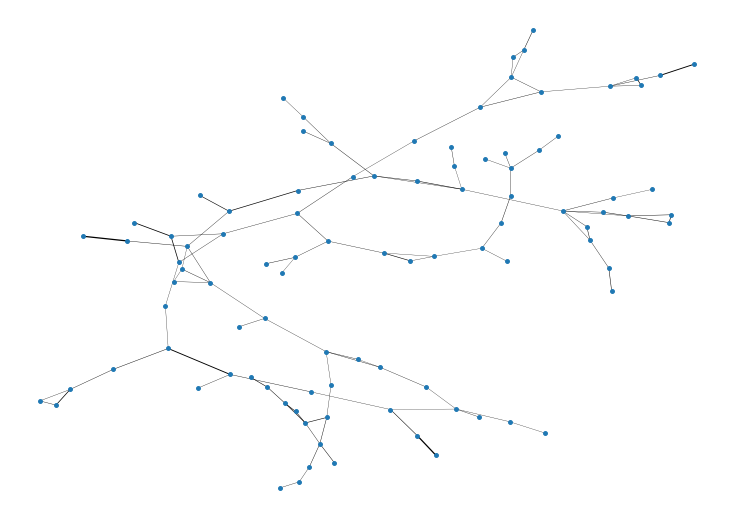

In [56]:
draw_subgraph(0) #largest subgraph

In [57]:
#draw_subgraph(0,range(2002,2008))

In [58]:
#draw_subgraph(0,range(2008,2013))

In [59]:
#draw_subgraph(0,range(2013,2018))

In [60]:
comp_no = 0 #component number based on decreasing size

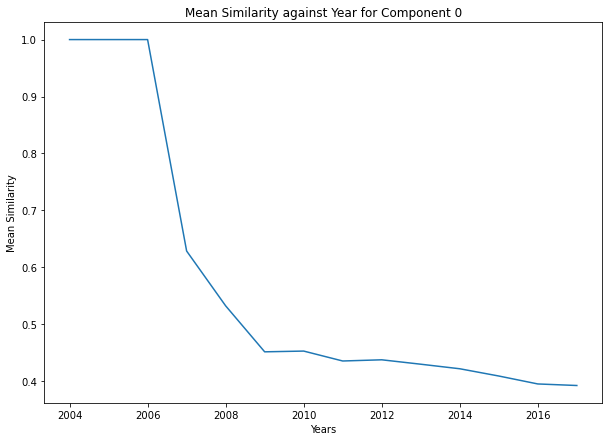

In [61]:
plt.title('Mean Similarity against Year for Component ' + str(comp_no))#for every pair of nodes
plt.xlabel('Years')
plt.ylabel('Mean Similarity')#including nodes which do not share an edge
avesim_x = [x for x in range(2002,2018)] #each year
avesim_y = [get_subgraph(comp_no,range(2002,x+1),True)[0] for x in avesim_x]
plt.plot(avesim_x,avesim_y)
plt.savefig('Mean Similarity against Year for Component ' + str(comp_no))
plt.show()

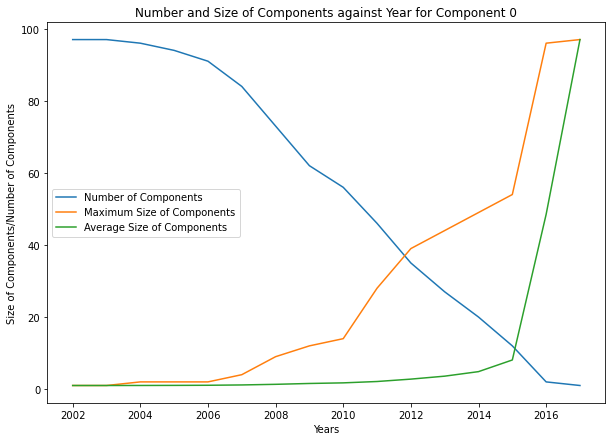

In [62]:
plt.title('Number and Size of Components against Year for Component ' + str(comp_no))
plt.xlabel('Years')
plt.ylabel('Size of Components/Number of Components')
avesim_x = [x for x in range(2002,2018)] #each year
avesim_y = [get_subgraph(comp_no,range(2002,x+1),True)[2] for x in avesim_x]
avesim_y1 = [get_subgraph(comp_no,range(2002,x+1),True)[3] for x in avesim_x]
avesim_y2 = [get_subgraph(comp_no,range(2002,x+1),True)[1] for x in avesim_x]
plt.plot(avesim_x,avesim_y2, label = 'Number of Components')
plt.plot(avesim_x,avesim_y1, label = 'Maximum Size of Components')
plt.plot(avesim_x,avesim_y, label = 'Average Size of Components')
plt.legend()
plt.savefig('Number and Size of Components against Year for Component ' + str(comp_no))
plt.show()

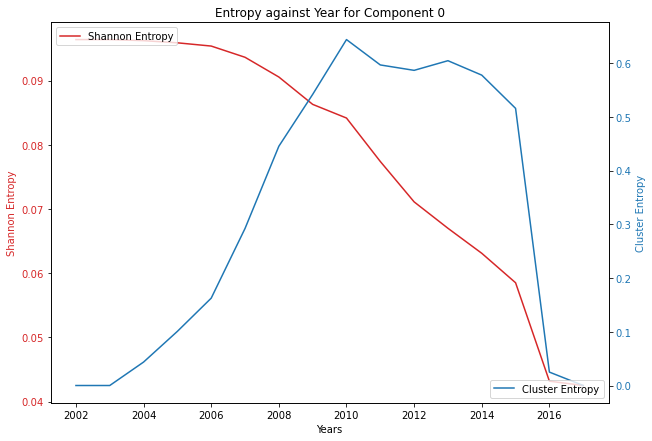

In [63]:
avesim_x = [x for x in range(2002,2018)] #each year
SG = DG.subgraph(comps[comp_no])
ent_y = [entropy(-1,filter_year(SG,range(2002,x+1))) for x in avesim_x]
ent_y1 = [clusterentropy(-1,filter_year(SG,range(2002,x+1))) for x in avesim_x]
fig, ax1 = plt.subplots()
color1 = "tab:red"
color2 = "tab:blue"
ax1.set_title('Entropy against Year for Component ' + str(comp_no))
ax1.set_xlabel('Years')
ax1.set_ylabel('Shannon Entropy', color = color1)
ax1.tick_params(axis='y', labelcolor = color1)
ax1.plot(avesim_x,ent_y, label = 'Shannon Entropy', color = color1)
ax2 = ax1.twinx()
ax2.set_ylabel('Cluster Entropy', color = color2)
ax2.tick_params(axis='y', labelcolor = color2)
ax2.plot(avesim_x,ent_y1, label = 'Cluster Entropy', color = color2)
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.savefig('Entropy against Year for Component ' + str(comp_no))
plt.show()

Number of Nodes = 97
Mean Similarity =  0.4514928193499621
Number of Connected Components = 62


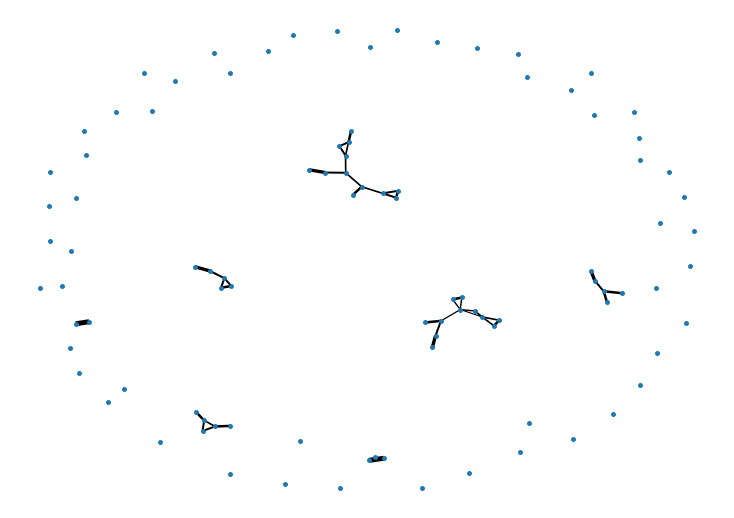

In [64]:
draw_subgraph(0,range(2002,2010))#where there is highest cluster entropy

In [65]:
def filter_year_range(Graph, isolate = True):
    #returns parameters with only edges from the list of years specified
    Y = nx.Graph()
    if isolate == True:
        Y.add_nodes_from(Graph.nodes()) #this line can be added if isolated nodes are also displayed
    edgelist = []
    for u,v in Graph.edges():
        for year in range(2002,2018):
            if year in Graph[u][v]['year']:
                edgelist.append((year,Graph[u][v]['year'][year],u,v))
    edgelist = sorted(edgelist)
    ret = []
    for i,edge in enumerate(edgelist):
        if i!=0 and edge[0] != edgelist[i-1][0]:
            tmp = getSize(Y)
            ret.append((np.mean(tmp),max(tmp),len(tmp),len(Y.nodes),Y.number_of_edges()))
            #print(len(tmp))
        Y.add_edge(edge[2],edge[3], weight = edge[1])
    tmp = getSize(Y)
    ret.append((np.mean(tmp),max(tmp),len(tmp),len(Y.nodes),Y.number_of_edges()))
    return ret

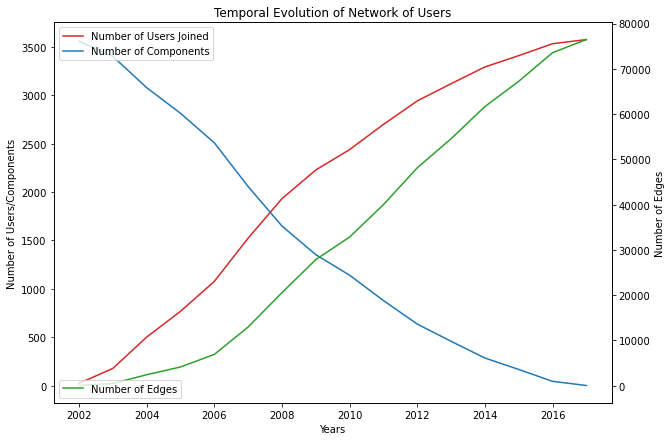

In [66]:
#Temporal Evolution of Entire Network (Using GC)
years_x = [x for x in range(2002,2018)] #each year
ret = filter_year_range(GC)
retFalse = filter_year_range(GC, False)
comps_y = [x[0] for x in ret]
comps_y2 = [x[2] for x in ret]
comps_y3 = [x[3] for x in retFalse]
comps_y4 = [x[4] for x in ret]
fig, ax1 = plt.subplots()
ax1.set_title('Temporal Evolution of Network of Users')
ax1.set_xlabel('Years')
ax1.set_ylabel('Number of Users/Components')
ax1.plot(years_x,comps_y3, label = 'Number of Users Joined', color = "tab:red")
ax1.plot(years_x,comps_y2, label = 'Number of Components', color = "tab:blue")
ax1.legend(loc = 'upper left')
ax2 = ax1.twinx()
ax2.plot(years_x,comps_y4, label = 'Number of Edges', color = "tab:green")
ax2.set_ylabel('Number of Edges')
ax2.legend(loc = 'lower left')
plt.savefig('Temporal Evolution of Network of Users.png')
plt.show()

In [67]:
import pickle
nx.write_gpickle(GC,'network_users.p')

In [68]:
W = nx.read_gpickle('network_users.p')

In [69]:
import community
partition = community.best_partition(GC, weight = 'weight', randomize = True)

In [70]:
clt.Counter(partition.values())

Counter({0: 953, 1: 170, 2: 773, 3: 698, 4: 841, 5: 29, 6: 110, 7: 2})

In [71]:
clt.Counter(partition.values())

Counter({0: 953, 1: 170, 2: 773, 3: 698, 4: 841, 5: 29, 6: 110, 7: 2})

In [72]:
community.modularity(partition,GC)#higher value better, between 0-1

0.24099141446929795

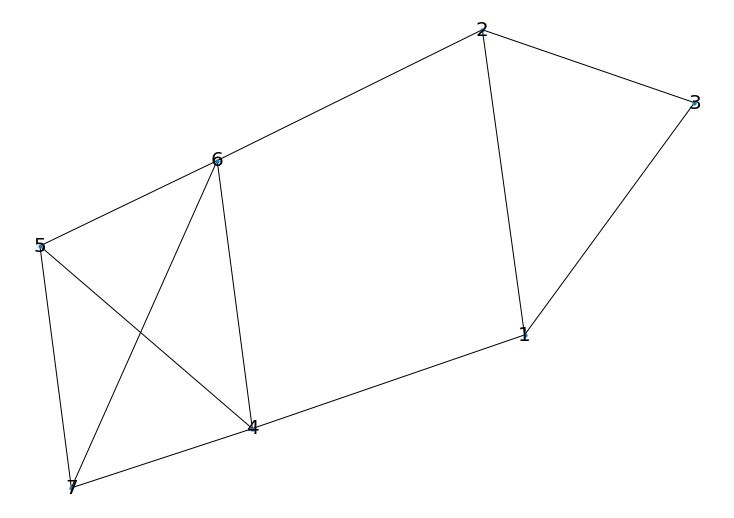

In [73]:
A = nx.Graph()
A.add_edge(1,2)
A.add_edge(2,3)
A.add_edge(3,1)
A.add_edge(1,4)
A.add_edge(4,5)
A.add_edge(4,6)
A.add_edge(4,7)
A.add_edge(5,6)
A.add_edge(6,7)
A.add_edge(5,7)
A.add_edge(2,6)
nx.draw(A, with_labels = True, font_size = 20, node_size = 10)

In [74]:
part = community.best_partition(A, randomize = True)
part

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1}

In [75]:
community.modularity(part,A)

0.28099173553719003

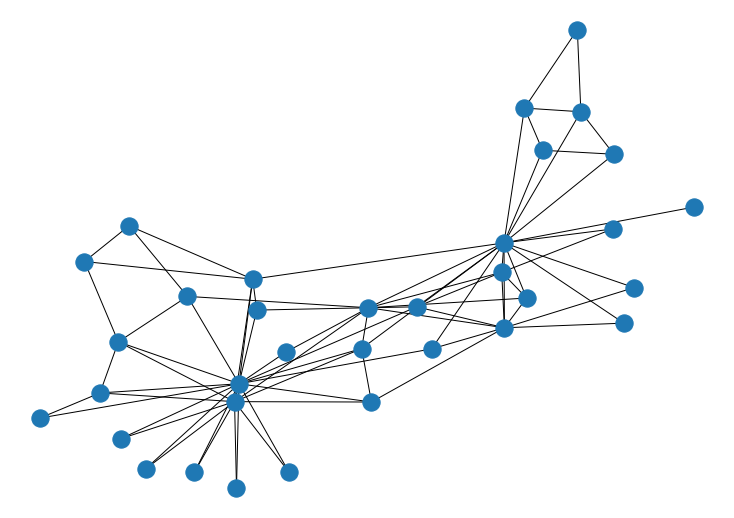

In [76]:
C = nx.karate_club_graph()
nx.draw(C)

In [77]:
part = community.best_partition(C)
part

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 1,
 5: 1,
 6: 1,
 7: 0,
 8: 2,
 9: 2,
 10: 1,
 11: 0,
 12: 0,
 13: 0,
 14: 2,
 15: 2,
 16: 1,
 17: 0,
 18: 2,
 19: 0,
 20: 2,
 21: 0,
 22: 2,
 23: 3,
 24: 3,
 25: 3,
 26: 2,
 27: 3,
 28: 3,
 29: 2,
 30: 2,
 31: 3,
 32: 2,
 33: 2}

In [78]:
community.modularity(part,C)

0.41978961209730437